# <center> CS 178: Machine Learning &amp; Data Mining </center>
## <center> Course Project: Analyzing the IMDb Movie Reviews Dataset</center>

## Requirement:
- `kNN`
- `logistic`
- `feedforward neural networks` (with at least 1 hidden layer)
- `at least 1 other type` of classifier (other than nearest-centroid): e.g., you could use a decision tree type of classifier (`random forests`, `gradient-boosted trees`, etc), a `support vector machine classifier`, a more specialized form of neural network (e.g., `convolutional model` for image datasets, or a **`recurrent neural network`** for text classification).
- you can have more if you wish and are free to explore classifiers that we did not discuss in class. You could also investigate if combinations (i.e., `ensembles`) of your classifiers produce better results than any classifier alone.

## import libraries

In [9]:
# Standard library imports
import math
import warnings
from typing import Tuple

# Third-party library imports
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from datasets import load_dataset
import seaborn as sns


# Scikit-learn imports
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import GridSearchCV


from sklearn.neighbors import KNeighborsClassifier, NearestCentroid # KNN classifier, Nearest centroid classifier
from sklearn.linear_model import LogisticRegression # Logistic classifier
from sklearn.neural_network import MLPClassifier # neural network classifier
from sklearn.tree import DecisionTreeClassifier, plot_tree # decision tree classifier

import warnings
warnings.filterwarnings('ignore')

seed = 1234 # Fix the random seed for reproducibility
np.random.seed(seed)  

## Load dataset
Load dataset and separate it into 3 subset: 
- X_train, y_train
- X_val, y_val
- X_test, y_test

Ratio: (5 : 2.5 : 2.5)

In [5]:
dataset = load_dataset("imdb") # Load the IMDB dataset from Hugging Face
# print(dataset) # view dataset
"""
    DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

    sentiment: 1 = positive; 0 = negative
    sample: {'text': 'I rented ...', 'label': 0}
"""

# train_data, val_data = train_test_split(dataset['train'][0], dataset['train'][1], test_size=0.2, random_state=seed) 

train_data = dataset['train']
test_data = dataset['test']

# convert huggingface dataset type to pandas dataframe
train_df = pd.DataFrame({'text': train_data['text'], 'label': train_data['label']})
test_df = pd.DataFrame({'text': test_data['text'], 'label': test_data['label']})

# split into train, validation, test set (ratio 25000:7500:17500)
X_train, y_train = train_df['text'], train_df['label']
X_val, X_test, y_val, y_test = train_test_split(test_df['text'], test_df['label'], test_size=0.5, random_state=seed)

print(X_train.shape, X_val.shape, X_test.shape)
print(X_train, y_train)

(25000,) (12500,) (12500,)
0        I rented I AM CURIOUS-YELLOW from my video sto...
1        "I Am Curious: Yellow" is a risible and preten...
2        If only to avoid making this type of film in t...
3        This film was probably inspired by Godard's Ma...
4        Oh, brother...after hearing about this ridicul...
                               ...                        
24995    A hit at the time but now better categorised a...
24996    I love this movie like no other. Another time ...
24997    This film and it's sequel Barry Mckenzie holds...
24998    'The Adventures Of Barry McKenzie' started lif...
24999    The story centers around Barry McKenzie who mu...
Name: text, Length: 25000, dtype: object 0        0
1        0
2        0
3        0
4        0
        ..
24995    1
24996    1
24997    1
24998    1
24999    1
Name: label, Length: 25000, dtype: int64


## Convert the text dataset into a feature space by doing text vectorization

In [16]:

# # create an instance of a CountVectorizer, using 'english' stopword; only keeping terms that occur in at least 2% of documents; allow only unigrams ("ngram_range=(1, 1)")
# vectorizer = CountVectorizer(stop_words='english', min_df=0.02, ngram_range=(1, 1)) # Convert a collection of text documents to a matrix of token counts.

# # transform a set of text data into a sparse Bag of Words (BoW) array
# # Each document in corpus (X_train) is represented as a vector of word counts.
# # The matrix will be sparse, meaning most of its values will be zeros (since most words do not appear in most documents) => memory and computational efficiency.
# vectorized_X_train = vectorizer.fit_transform(X_train)  # fits the vectorizer to the training data (learns the vocabulary) and then transforms the training data into a sparse matrix

# """ Rows represent documents in the dataset.
#     Columns represent unique words (features) in the vocabulary 
#     Values in the matrix represent the frequency of each word in the corresponding document.
    
# | Document | I | love | programming | is | fun | machine | learning |
# | -------- | - | ---- | ----------- | -- | --- | ------- | -------- |
# | 1        | 1 | 1    | 1           | 0  | 0   | 0       | 0        |
# | 2        | 0 | 0    | 1           | 1  | 1   | 0       | 0        |
# | 3        | 1 | 1    | 0           | 0  | 0   | 1       | 1        |
# """

# print(vectorized_X_train.shape) # (25000, 784) => 25000 number of documents (movie reviews); 784: This corresponds to the number of features (or tokens) in the feature space, which is 784 unique words or tokens in the training set after applying the CountVectorizer. These words make up the vocabulary.
# print(vectorized_X_train[0])    # Coords    Values
#                                 #  (0,728)    1  => this means the token represented by feature 728rd has frequency of 1 in the first row 

# print(vectorized_X_train[:5])    # this is the frequency of words in the first 5 rows                          

In [6]:
# Vectorize the text using TF-IDF
# - using ngram_range=(1,2) to capture multi-word phrases like “not great”, “very bad”, etc.
vectorizer = TfidfVectorizer(stop_words='english', lowercase=True, min_df=0.02, ngram_range=(1, 2)) 
X_train_vectorized = vectorizer.fit_transform(X_train)
# print(X_train_vectorized[0])  # tf-idf score of tokens in the first row (first review)
"""
Coords	    Values
(0, 748)	0.09384584566506636     => the token represented by the 748th feature in row 0 has score 0.09384584566506636
(0, 571)	0.10410843943135543
...
"""


# Transform the validation set using the same vectorizer
X_val_vectorized = vectorizer.transform(X_val)  

# Transform the test set using the same vectorizer
X_test_vectorized = vectorizer.transform(X_test) 

---
## Data visualization: 

Plot the top 20 words with highest TF-IDF scores

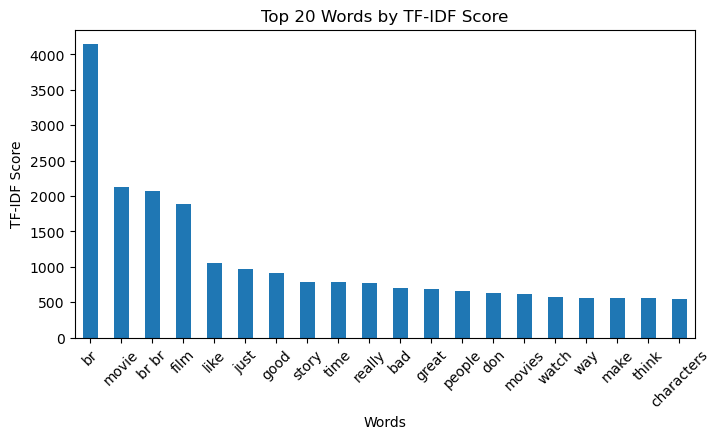

In [18]:
def bar_chart_top_n_words_with_high_tfidf(n):
    # Get feature names (words in our vocabulary)
    feature_names = np.array(vectorizer.get_feature_names_out())
    # print(feature_names[:5]) # ['10' '20' '30' '80' 'able']

    # Get the TF-IDF scores for each word in the first document
    scores = X_train_vectorized.toarray()
    # print(scores.shape) # (25000, 808)
    """ 
    [[0.         0.         0.         ... 0.         0.         0.07747023]
    [0.         0.         0.         ... 0.         0.         0.        ]
    [0.         0.         0.         ... 0.         0.         0.        ]
    ...
    ]
    """

    # Sum the TF-IDF scores for each word across all documents
    word_scores = np.sum(scores, axis=0)
    # print(word_scores) # (808,)
    """ 
    [ 407.6091415    94.16585668   87.99444704   85.53918911  145.38221937
    185.34731773  145.74034136  101.99891804  535.41810334  333.8988697
    246.49865795  412.13013595  148.34809517   98.42278875  358.25223398
    ...
    ]
    """

    # Create a DataFrame of word scores
    word_scores_df = pd.DataFrame(word_scores, index=feature_names, columns=['TF-IDF'])
    word_scores_df = word_scores_df.sort_values(by='TF-IDF', ascending=False)
    # print(word_scores_df)
    """
                    TF-IDF
    br         4143.389148
    movie      2123.105117
    br br      2075.316470
    ...                ...
    """

    # Plot the top n words
    word_scores_df.head(n).plot(kind='bar', figsize=(8, 4), legend=False)
    plt.title('Top 20 Words by TF-IDF Score')
    plt.xlabel('Words')
    plt.ylabel('TF-IDF Score')
    plt.xticks(rotation=45)
    plt.show()

bar_chart_top_n_words_with_high_tfidf(20)

Plot a histogram of how many unique words are in each review

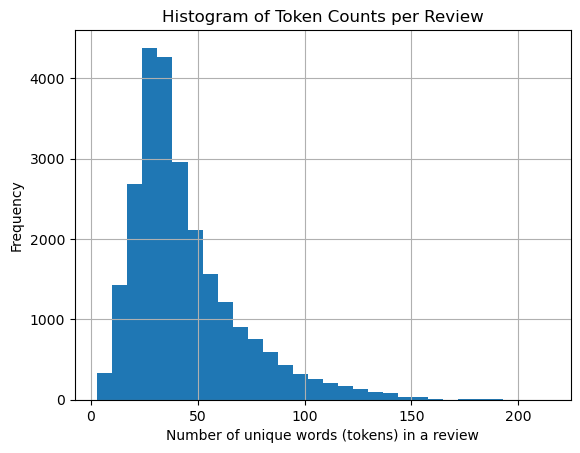

In [19]:
def review_word_count_histgram(X):
    '''
    X: Sparse matrix (e.g., TF-IDF matrix)
    '''
    token_counts = np.array([x.count_nonzero() for x in X])  # Count non-zero values in each row
    plt.hist(token_counts, bins=30)
    plt.title('Histogram of Token Counts per Review')
    plt.xlabel('Number of unique words (tokens) in a review')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

review_word_count_histgram(X_train_vectorized)

Vocabulary size: number of unique words in the training set. This is important to understand the size of the feature space.

In [20]:
print("Vocabulary Size:", len(np.array(vectorizer.get_feature_names_out())))

Vocabulary Size: 808


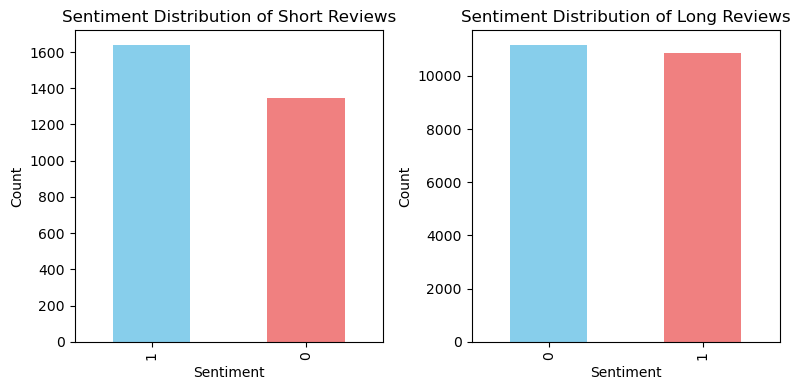

In [21]:
X_train_review_length = X_train.apply(lambda x: len(x.split()))


# Define short and long reviews based on length
short_reviews = X_train[X_train_review_length <= 100]
long_reviews = X_train[X_train_review_length > 100]

short_reviews_label = y_train[X_train_review_length <= 100]
long_reviews_label = y_train[X_train_review_length > 100]


# Plot sentiment distribution for short vs long reviews
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
short_reviews_label.value_counts().plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Sentiment Distribution of Short Reviews')
plt.xlabel('Sentiment')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
long_reviews_label.value_counts().plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Sentiment Distribution of Long Reviews')
plt.xlabel('Sentiment')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

           positive  negative      diff
great      0.039712  0.015265  0.024448
best       0.028664  0.013170  0.015494
love       0.028993  0.013515  0.015478
excellent  0.016516  0.003485  0.013031
wonderful  0.014278  0.002736  0.011541
life       0.025916  0.015429  0.010486
beautiful  0.014099  0.005076  0.009022
perfect    0.011713  0.003140  0.008573
amazing    0.010936  0.002467  0.008469
loved      0.011813  0.003501  0.008311


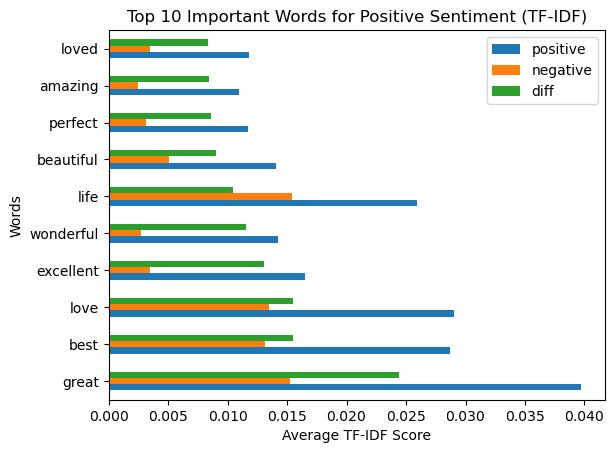

In [22]:
# Convert y_train to a numpy array (if it's a pandas Series)
y_train = np.array(y_train)

# create boolean masks for positive/negative reviews
positive_mask = y_train == 1  
negative_mask = y_train == 0  

# Index the sparse matrix using the boolean masks
positive_reviews_tfidf = X_train_vectorized[positive_mask]
negative_reviews_tfidf = X_train_vectorized[negative_mask]

# Get the average TF-IDF score for each word (feature) in positive and negative reviews
positive_avg_tfidf = np.array(positive_reviews_tfidf.mean(axis=0)).flatten()
negative_avg_tfidf = np.array(negative_reviews_tfidf.mean(axis=0)).flatten()

# Get the feature names (words)
words = vectorizer.get_feature_names_out()

# Create DataFrames to compare positive and negative TF-IDF scores
df_positive = pd.DataFrame(positive_avg_tfidf, index=words, columns=['positive'])
df_negative = pd.DataFrame(negative_avg_tfidf, index=words, columns=['negative'])

# Merge DataFrames to compare positive vs negative sentiment
df_comparison = pd.concat([df_positive, df_negative], axis=1)

# Calculate the difference in TF-IDF scores between positive and negative reviews
df_comparison['diff'] = df_comparison['positive'] - df_comparison['negative']

# Sort the DataFrame by the difference to find the most important words for positive sentiment
df_comparison = df_comparison.sort_values(by='diff', ascending=False)
print(df_comparison.head(10))

# Plot the top 10 most important words for positive sentiment
df_comparison.head(10).plot(kind='barh')
plt.title('Top 10 Important Words for Positive Sentiment (TF-IDF)')
plt.xlabel('Average TF-IDF Score')
plt.ylabel('Words')
plt.show()

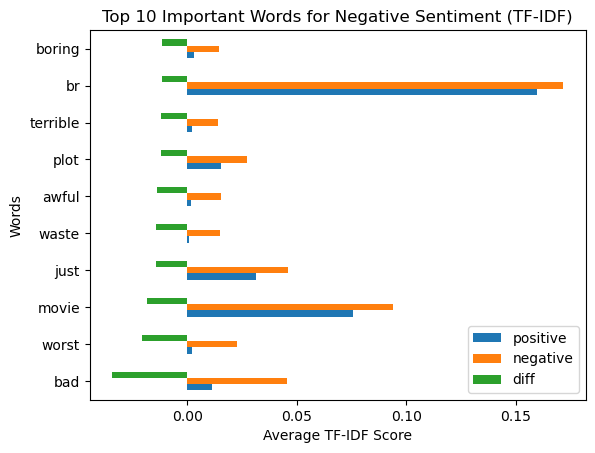

In [23]:
# Sort the DataFrame by the difference to find the most important words for negative sentiment
df_comparison = df_comparison.sort_values(by='diff', ascending=True)

# Plot the top 10 most important words for negative sentiment
df_comparison.head(10).plot(kind='barh')
plt.title('Top 10 Important Words for Negative Sentiment (TF-IDF)')
plt.xlabel('Average TF-IDF Score')
plt.ylabel('Words')
plt.show()

---
## Classifier experiments

### KNN classifier

---
### Logistic classifier

---
### Neural network classifier

#### Study learning curves by varying **learning rate** to see how this affect the model performance

In this experiment, we would use the following settings for our network:
- A single hidden layer with $64$ hidden nodes
- Use the ReLU activation function
- Train the network using stochastic gradient descent (SGD)
- Set `n_iter_no_change=100` and `max_iter=200`
- Use a batch size of 256
- **Make sure to set `random_state=seed`.**
- learning rate will be varied and take these values: `[0.001, 0.01, 0.1, 1.5]`.

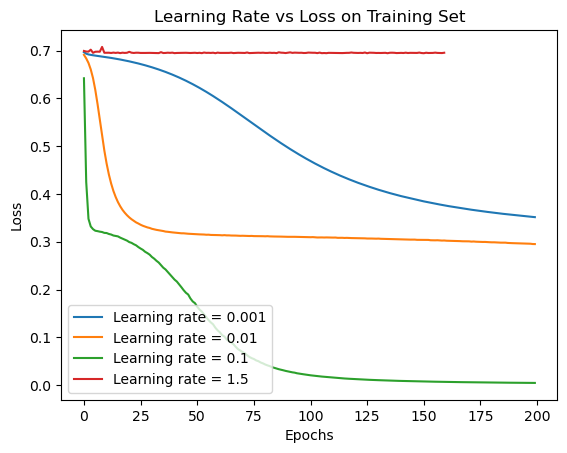

In [19]:
def errors_for_learning_rates_mlp(X_tr: np.array, y_tr: np.array, seed: int, learning_rates: list[float]) -> list[list]:
    err_curves = [] # append loss_curve_ from each MLP model to this list
    for lr in learning_rates:
        mlp_classifier = MLPClassifier(hidden_layer_sizes=(64,), activation='relu', solver='sgd', batch_size=256, learning_rate_init=lr, n_iter_no_change=100, max_iter=200,random_state=seed)
        mlp_classifier.fit(X_tr, y_tr)  
        err_curves.append(mlp_classifier.loss_curve_)
    return err_curves 

def plot_errors_for_learning_rates_mlp(err_curves: list[list], learning_rates: list[float]) -> None:
    for i, curve in enumerate(err_curves):
        plt.plot(curve, label=f'Learning rate = {learning_rates[i]}')  # plot the loss curve for each learning rate
    plt.xlabel('Epochs') # epochs: number of times the training set is passed through the model during the training process.
    plt.ylabel('Loss')
    plt.title('Learning Rate vs Loss on Training Set')
    plt.legend()
    
learning_rates = [0.001, 0.01, 0.1, 1.5]
err_curves = errors_for_learning_rates_mlp(X_train_vectorized, y_train, seed, learning_rates)
plot_errors_for_learning_rates_mlp(err_curves, learning_rates)


From this result, we can tell a lot how varying learning rates can affect the model performance.
- For very Small Learning Rate (0.001): the model improves very slowly and may fail to converge within a reasonable number of iterations. The gradient updates are so small that the model might get stuck and not make significant progress.

- For medium learning Rates (0.01, 0.1): the model can eventually converge. However, it may get stuck in local minima, meaning it finds a suboptimal solution, and may or may not be able to escape. If it reached the global minimum, the loss would drop to zero. However, this is often acceptable in practice, as there’s a trade-off between achieving very high accuracy and keeping the model complexity manageable.

- On the other hand, we see that for very high learning rate (1.5): the model’s updates are too large, causing it to overshoot optimal values during training. As a result, the loss remains very high, and the model struggles to converge properly, resulting in poor performance.

=> From this experiment, we decided to choose a learning rate of 0.1 for our model

(when we say that a model "converges", we are referring to the point at which the learning process of the model reaches stability, and further training no longer results in significant changes to the model’s performance. Convergence typically refers to the optimization process where the model's parameters have been updated to the point where the loss function has reached a minimum, or is no longer improving)

#### Study learning curves by varying training size to see how this affect the model performance

In this experiment, we would use the following settings for our network:
- A single hidden layer with $64$ hidden nodes
- Use the ReLU activation function
- Train the network using stochastic gradient descent (SGD)
- Set `n_iter_no_change=100` and `max_iter=200`
- Use a batch size of 256
- learning rate = 0.1
- training size will be varied and take values in [50, 500, 2000, 5000, 10000, 20000]


In [24]:
def errors_for_train_sizes_mlp(X_tr: np.array, y_tr: np.array, X_te: np.array, y_te: np.array, seed: int, train_sizes: list[int], learning_rate: str = 'constant', learning_rate_init: float = 0.1, hidden_layer_sizes: tuple = (64,), activation: str = 'relu', solver: str = 'sgd') -> tuple[list, list, list, list]:
    # append error rates to the following lists
    tr_err_mlp = [] # training error rates for MLP
    te_err_mlp = [] # testing error rates for MLP
    # mlp_classifier = MLPClassifier(hidden_layer_sizes=(64,), activation='relu', solver='sgd', batch_size=256, learning_rate_init=learning_rate,random_state=seed)
    mlp_classifier = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, activation=activation, solver=solver, batch_size=256, learning_rate_init=learning_rate_init,random_state=seed, n_iter_no_change=100, max_iter=200)

    for n_tr in train_sizes:
        sub_X_tr = X_tr[:n_tr]
        sub_y_tr = y_tr[:n_tr]
        mlp_classifier.fit(sub_X_tr, sub_y_tr) # train model

        tr_err_mlp.append(1 - mlp_classifier.score(sub_X_tr, sub_y_tr))  # training error (mlp_classifier.score() return accuracy score)
        te_err_mlp.append(1 - mlp_classifier.score(X_te, y_te))      # testing error (which is actually the validation error)
    return tr_err_mlp, te_err_mlp 



def plot_errors_for_train_sizes_mlp(tr_err_mlp: list, te_err_mlp: list, train_sizes: list[int], lr: float) -> None:
    # Create a plot of the training error and testing error for both the logistic regression and MLP models 
    # as a function of the number of training data points. 
    # in your plot. Use a log-scale on the x-axis. 
    plt.figure(figsize=(5, 3))
    
    # plot training/testing errors for mlp
    plt.semilogx(train_sizes, tr_err_mlp, label='training error') # semilogx() scales x-axis logarithmically
    plt.semilogx(train_sizes, te_err_mlp, label='validation error')
    
    plt.xlabel('Number of training datapoints')
    plt.ylabel('Error Rate')
    plt.legend() # adding legend
    plt.title('Error Rate by Different Number of Training Datapoints (lr = ' + str(lr) + ')')
    plt.show()




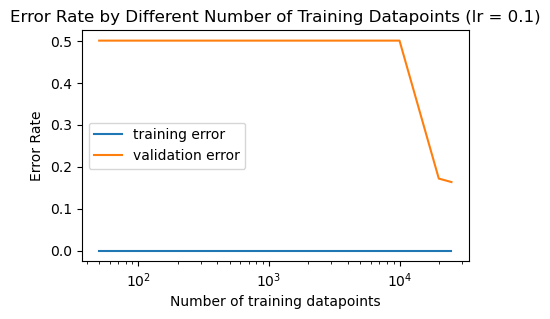

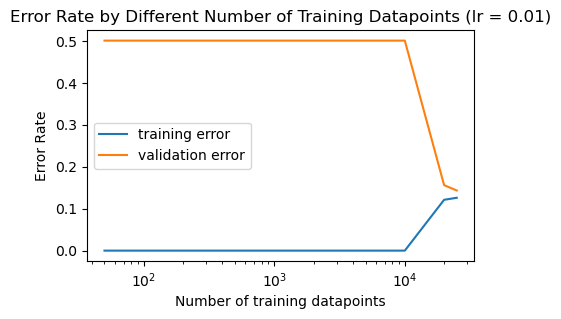

In [25]:
train_sizes = [50, 500, 2000, 5000, 10000, 20000, 25000]
tr_err_mlp, te_err_mlp = errors_for_train_sizes_mlp(X_train_vectorized, y_train, X_val_vectorized, y_val, seed, train_sizes, learning_rate_init=0.1, hidden_layer_sizes=(64,), activation='relu', solver='sgd')
plot_errors_for_train_sizes_mlp(tr_err_mlp, te_err_mlp, train_sizes, 0.1)

tr_err_mlp, te_err_mlp = errors_for_train_sizes_mlp(X_train_vectorized, y_train, X_val_vectorized, y_val, seed, train_sizes, learning_rate_init=0.01, hidden_layer_sizes=(64,), activation='relu', solver='sgd')
plot_errors_for_train_sizes_mlp(tr_err_mlp, te_err_mlp, train_sizes, 0.01)


=> this indicates overfitting when training set is < 20000

#### Complexity-error tradeoffs tests

In [27]:

# figure, axes = plt.subplots(8, 4, figsize=(12, 12)) 

hidden_layer_sizes = [(64,), (64,128), (256, 256), (64,64,64)]
learning_rates= ['constant', 'adaptive']
activations = ['relu', 'logistic']
solvers = ['adam', 'sgd']

results = []
    
for i, hidden_layer_size in enumerate(hidden_layer_sizes):
    for j, learning_rate in enumerate(learning_rates):
        for k, activation in enumerate(activations):
            for l, solver in enumerate(solvers):
                # train a new model
                mlp_classifier = MLPClassifier(hidden_layer_sizes=hidden_layer_size, learning_rate=learning_rate, activation=activation, solver=solver, batch_size=256, learning_rate_init=0.1,random_state=seed, n_iter_no_change=100, max_iter=200)
                mlp_classifier.fit(X_train_vectorized, y_train) 
                
                train_accuracy = mlp_classifier.score(X_train_vectorized, y_train)
                val_accuracy = mlp_classifier.score(X_val_vectorized, y_val)
                results.append((hidden_layer_size, learning_rate, activation, solver, train_accuracy, val_accuracy))

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=['hidden_layer_size', 'learning_rate', 'activation', 'solver', 'train_accuracy', 'val_accuracy'])
# print(results_df) # print out the table

# Sort results by validation accuracy in descending order
results_df = results_df.sort_values(by='val_accuracy', ascending=False)

# print out the best model
best_model = results_df.iloc[0]
print(f"Best Model: {best_model}")


   hidden_layer_size learning_rate activation solver  train_accuracy  \
0              (64,)      constant       relu   adam         0.99924   
1              (64,)      constant       relu    sgd         1.00000   
2              (64,)      constant   logistic   adam         0.99992   
3              (64,)      constant   logistic    sgd         0.86672   
4              (64,)      adaptive       relu   adam         0.99924   
5              (64,)      adaptive       relu    sgd         1.00000   
6              (64,)      adaptive   logistic   adam         0.99992   
7              (64,)      adaptive   logistic    sgd         0.86676   
8          (64, 128)      constant       relu   adam         0.98140   
9          (64, 128)      constant       relu    sgd         0.96724   
10         (64, 128)      constant   logistic   adam         0.99788   
11         (64, 128)      constant   logistic    sgd         0.86680   
12         (64, 128)      adaptive       relu   adam         0.9

In [45]:
# add an index column to results_df
results_df['index'] = results_df.index
results_sorted_by_index = results_df.sort_values(by='index')
results_sorted_by_index.insert(0, 'index', results_sorted_by_index.pop('index'))

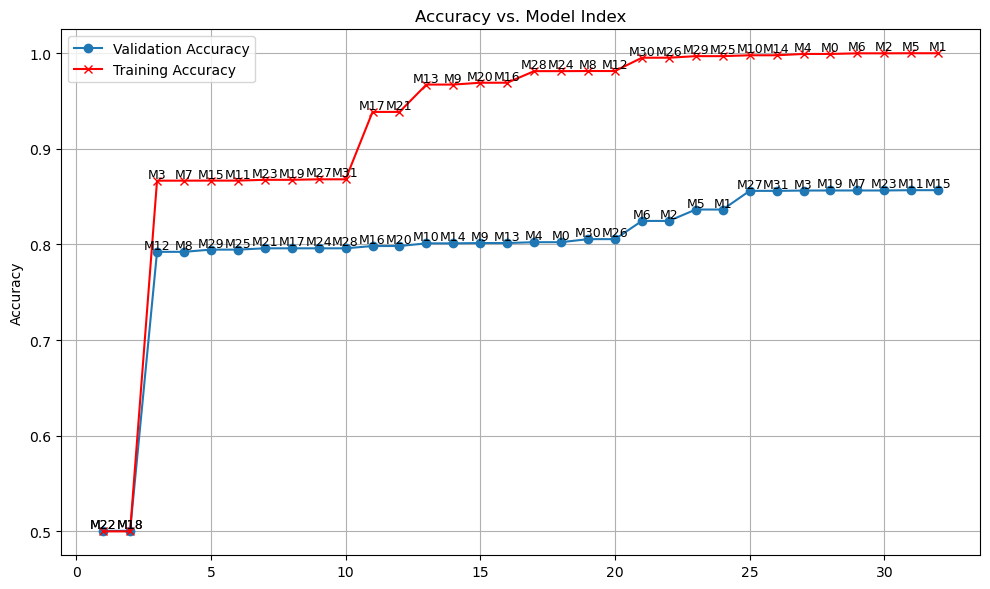

In [72]:

plt.figure(figsize=(10, 6))

# plot validation accuracy as a line chart
results_sorted_by_validation_accuracy = results_sorted_by_index.sort_values(by='val_accuracy')
val_accuracy = results_sorted_by_validation_accuracy["val_accuracy"]
indices_by_original_order = results_sorted_by_validation_accuracy["index"]
indices = list(range(1, len(val_accuracy) + 1))
plt.plot(indices, val_accuracy, marker='o', linestyle='-', label='Validation Accuracy')
for i, val in enumerate(val_accuracy): # Add labels for each point according to the original order of the models
    plt.text(indices[i], val, "M" + str(list(indices_by_original_order)[i]), fontsize=9, ha='center', va='bottom')


# plot the training accuracy
results_sorted_by_training_accuracy = results_sorted_by_index.sort_values(by='train_accuracy')
train_accuracy = results_sorted_by_training_accuracy["train_accuracy"]
indices_by_original_order_training = results_sorted_by_training_accuracy["index"]
plt.plot(indices, train_accuracy, marker='x', linestyle='-', color='r', label='Training Accuracy')
for i, val in enumerate(train_accuracy): # Add labels for each point according to the original order of the models
    plt.text(indices[i], val, "M" + str(list(indices_by_original_order_training)[i]), fontsize=9, ha='center', va='bottom')



# Customize the plot
plt.title('Accuracy vs. Model Index')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

####
Performs a hyperparameter search using GridSearchCV to find the best combination of hyperparameters for training the MLPClassifier. Hyperparameters are chosen from
```
    param_grid = {
        'hidden_layer_sizes': [(64,), (64, 64), (64, 128)],  # Different layer structures
        'activation': ['relu', 'tanh', 'logistic'],  # Activation functions
        'solver': ['adam', 'sgd'],  # Solvers
        'learning_rate': ['constant', 'adaptive'],  # Learning rates
        'learning_rate_init': [0.1],  # Learning rates
    }
```

The GridSearchCV is fitted on the training data (X_train_vectorized and y_train). It will try every combination of the hyperparameters and evaluate the model using cross-validation.

After finding the best hyperparameters (based on accuracy) across the cross-validation folds, evaluates the performance of the model on the validation set to understand how well the chosen model generalizes to unseen data.

In [50]:

# Define the hyperparameters and their possible values to search
param_grid = {
    'hidden_layer_sizes': [(64,), (64, 64), (64, 128)],  # Different layer structures
    'activation': ['relu', 'tanh', 'logistic'],  # Activation functions
    'solver': ['adam', 'sgd'],  # Solvers
    'learning_rate': ['constant', 'adaptive'],  # Learning rates
    'learning_rate_init': [0.1],  # Learning rates
}

# Create the MLP classifier (without specifying hyperparameters)
mlp = MLPClassifier(random_state=seed)

# Set up GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)

# Fit GridSearchCV
grid_search.fit(X_train_vectorized, y_train)

# Best hyperparameters found
print("Best Hyperparameters Found:", grid_search.best_params_)

# Evaluate on the validation set with the best hyperparameters
best_mlp = grid_search.best_estimator_
y_val_pred_best = best_mlp.predict(X_val_vectorized)
val_accuracy_best = accuracy_score(y_val, y_val_pred_best)
print(f"Validation Accuracy with Best Hyperparameters: {val_accuracy_best}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/opt/anaconda3/envs/cs178/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/cs178/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/cs178/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/cs178/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/cs17

Best Hyperparameters Found: {'activation': 'logistic', 'hidden_layer_sizes': (64,), 'learning_rate': 'constant', 'learning_rate_init': 0.1, 'solver': 'sgd'}
Validation Accuracy with Best Hyperparameters: 0.85392


#### output from the shell above:
Fitting 5 folds for each of 36 candidates, totalling 180 fits 

ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

...

Best Hyperparameters Found: {'activation': 'logistic', 'hidden_layer_sizes': (64,), 'learning_rate': 'constant', 'learning_rate_init': 0.1, 'solver': 'sgd'}

Validation Accuracy with Best Hyperparameters: 0.85392

#### confusion matrix

- Precision: ratio of correctly predicted positive observations to total predicted positives (how many reviews predicted as positive are actually positive)
= 0.8494674185463659

- Recall: ratio of correctly predicted positive observations to all observations in the actual class (how many positive reviews can we predict)
= 0.8667092856001278

Accuracy: 0.84704
Precision: 0.8408625846056981
Recall: 0.8556783597629345


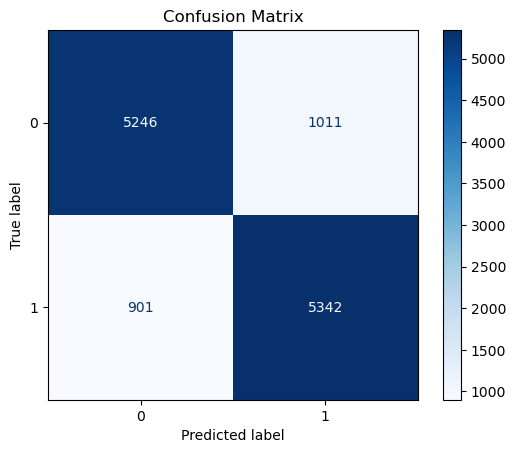

In [82]:
# the best model is model 15th from results_df => we will use this model to test on the validation set again and draw the confusion matrix
best_mlp_M15 = MLPClassifier(activation='logistic', hidden_layer_sizes=(64,128), learning_rate='adaptive', learning_rate_init=0.1, solver='sgd', batch_size=256, random_state=seed, n_iter_no_change=100, max_iter=200)
best_mlp_M15.fit(X_train_vectorized, y_train)


Accuracy: 0.8568
Precision: 0.8502430610004704
Recall: 0.8665494645996484


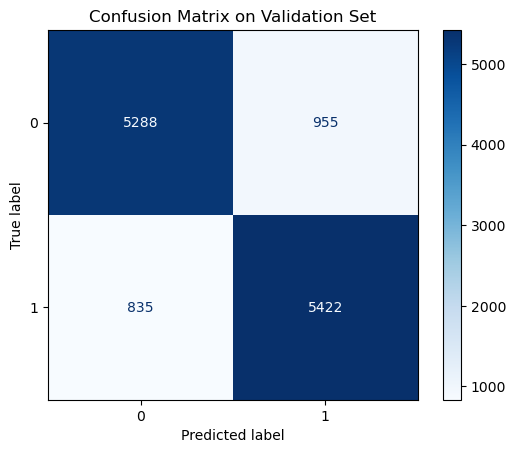

In [86]:

y_pred = best_mlp_M15.predict(X_val_vectorized)  
y_true = y_val

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])  # binary classification (0, 1) to sentiment (negative, positive)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix on Validation Set")
plt.show()


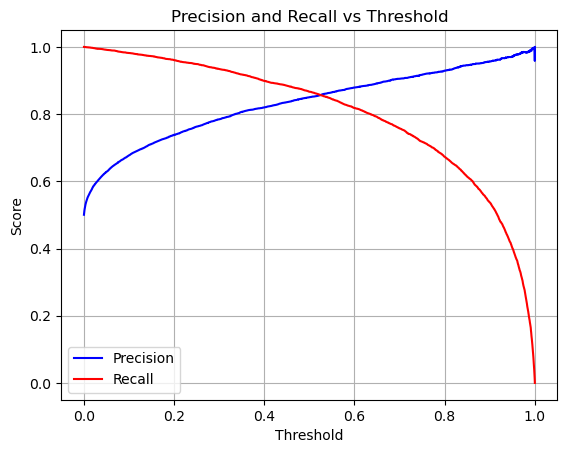

In [87]:
# calculates precision, recall, thresholds for various threshold between 0 and 1, range from the lowest predicted probability to the highest.
precision_vals, recall_vals, thresholds = precision_recall_curve(y_true, best_mlp_M15.predict_proba(X_val_vectorized)[:, 1])

# Plot Precision and Recall
plt.plot(thresholds, precision_vals[:-1], label='Precision', color='blue')
plt.plot(thresholds, recall_vals[:-1], label='Recall', color='red')

# Labels and title
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend(loc='best')

# Display the plot
plt.grid(True)
plt.show()

=> As the threshold increases, precision increases (because we are making fewer positive predictions) but recall decreases (because we miss more actual positive instances)

=> Based on the context of movie reviews classification, we may want to prioritize precision (correctness of our prediction), as we don't want to recommend bad movies based on incorrect positive sentiment and we want to ensure every review labeled as "positive" is truly positive.

=> we may increase the threshold to above the standard value of 0.5, but not too much to avoid recall score going too low
=> I'd choose a threshold of 0.6

Precision: 0.905289287760168
Recall: 0.757711363273134


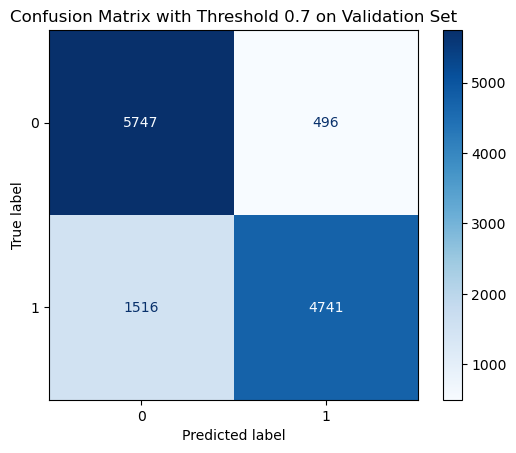

In [90]:
# redraw the confusion matrix with the new threshold
y_pred_new = (best_mlp.predict_proba(X_val_vectorized)[:, 1] >= 0.7).astype(int)
cm_new = confusion_matrix(y_val, y_pred_new)
disp_new = ConfusionMatrixDisplay(confusion_matrix=cm_new, display_labels=[0, 1])
disp_new.plot(cmap='Blues')
plt.title("Confusion Matrix with Threshold 0.7 on Validation Set")

# print new precision and recall 
precision_new = precision_score(y_val, y_pred_new)
recall_new = recall_score(y_val, y_pred_new)
print(f'Precision: {precision_new}')
print(f'Recall: {recall_new}')

plt.show()


Accuracy: 0.83272
Precision: 0.8970925784238715
Recall: 0.7512413903572001


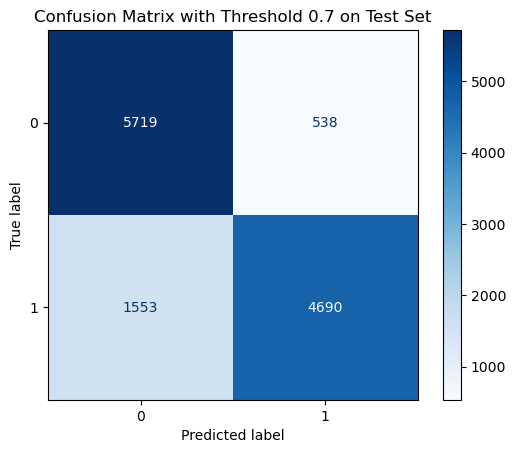

In [92]:
# use the best model to test on the test set, using a threshold of 0.7

# y_pred = best_mlp_M15.predict(X_test_vectorized)  # This uses the default threshold of 0.5
y_pred = (best_mlp_M15.predict_proba(X_test_vectorized)[:, 1] >= 0.7).astype(int)
y_true = y_test

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')

cm_new = confusion_matrix(y_true, y_pred)
disp_new = ConfusionMatrixDisplay(confusion_matrix=cm_new, display_labels=[0, 1])
disp_new.plot(cmap='Blues')
plt.title("Confusion Matrix with Threshold 0.7 on Test Set")
plt.show()



In [ ]:
# 